In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import ConfusionMatrixDisplay, RocCurveDisplay, confusion_matrix, classification_report, recall_score, precision_score, f1_score

from sklearn.linear_model import LogisticRegression

from imblearn.over_sampling import RandomOverSampler

In [10]:
df = pd.read_csv('../data/reviews_with_ratings_cleaned.csv', index_col = 'Unnamed: 0', keep_default_na = False)
df.sample(5)

,listing_id,id,date,reviewer_id,reviewer_name,comments,avg_rating,avg_score_below_4,avg_score_below_5th_percentile,comments_clean
288282,589049807707578914,894903659543157709,2023-05-19,14138182,Velia,If you wanna stay in a calm neighbourhood of W...,4.914286,0,0,if you wanna stay in a calm neighbourhood of w...
204458,35414659,760982034,2021-05-22,132049746,Jennifer,Very nice. Let us check in early. Tub looked l...,4.451429,0,0,very nice let us check in early tub looked lik...
298547,662243699702594697,834150271093133672,2023-02-24,60275855,Kelly,Wonderful location! I booked at the last minu...,4.920000,0,0,wonderful location i booked at the last minute...
91588,15523073,277063585,2018-06-15,15490708,Molly,I am an AirBnB host and have stayed in many Ai...,4.950000,0,0,i am an airbnb host and have stayed in many ai...
182148,29701036,534261509,2019-09-22,261527030,Jake,Felt right at home at Randy’s place. He was ve...,4.901429,0,0,felt right at home at randy s place he was ver...


In [11]:
df.isnull().sum()

listing_id                        0
id                                0
date                              0
reviewer_id                       0
reviewer_name                     0
comments                          0
avg_rating                        0
avg_score_below_4                 0
avg_score_below_5th_percentile    0
comments_clean                    0
dtype: int64

In [12]:
print(df['avg_score_below_5th_percentile'].value_counts()),
print('*'*30)
df['avg_score_below_5th_percentile'].value_counts(normalize = True)

avg_score_below_5th_percentile
0    320774
1      2033
Name: count, dtype: int64
******************************


avg_score_below_5th_percentile
0    0.993702
1    0.006298
Name: proportion, dtype: float64

In [13]:
X = df[['comments_clean']] # Had to make it double square brackets to make it a 2D array
X.shape

(322807, 1)

In [14]:
y = df['avg_score_below_5th_percentile']
y.shape

(322807,)

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42, stratify = y)

In [16]:
X_train

,comments_clean
67125,our client michael stayed for one evening and ...
63788,just a wonderful experience all around locatio...
20242,this airbnb was beautiful it is really close t...
160237,great stay
247799,super easy check in and great location
...,...
178131,jen and john s place is perfect for both perso...
103396,ashley has done a great job of selling her pla...
150074,this is the nicest basement apt in dc we ve st...
304472,i booked a last minute trip to d c and was loo...


In [17]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((242105, 1), (80702, 1), (242105,), (80702,))

#### Will random over sample the minority class

In [18]:
ros = RandomOverSampler(random_state = 42) # Added Random State for replicability

In [19]:
X_train_over, y_train_over = ros.fit_resample(X_train, y_train)

In [20]:
X_train_over

,comments_clean
0,our client michael stayed for one evening and ...
1,just a wonderful experience all around locatio...
2,this airbnb was beautiful it is really close t...
3,great stay
4,super easy check in and great location
...,...
481155,the host was very accommodating and communicat...
481156,very convenient location for my 10 week job in...
481157,great place in dc for a quick stay easy check ...
481158,a cool stay for the week


In [21]:
X_train_over.isnull().sum()

comments_clean    0
dtype: int64

In [22]:
y_train_over

0         0
1         0
2         0
3         0
4         0
         ..
481155    1
481156    1
481157    1
481158    1
481159    1
Name: avg_score_below_5th_percentile, Length: 481160, dtype: int64

In [23]:
X_train.shape, y_train.shape

((242105, 1), (242105,))

In [24]:
X_train_over.shape, y_train_over.shape

((481160, 1), (481160,))

#### The minority class (below 5th percentile) is now balanced with the majority class (above 5th percentile)

In [25]:
y_train.value_counts()

avg_score_below_5th_percentile
0    240580
1      1525
Name: count, dtype: int64

In [26]:
y_train_over.value_counts()

avg_score_below_5th_percentile
0    240580
1    240580
Name: count, dtype: int64

#### Will run a TFidfVectorizer first without a GridSearch

In [27]:
tf = TfidfVectorizer(stop_words = 'english')

In [28]:
X_train_over

,comments_clean
0,our client michael stayed for one evening and ...
1,just a wonderful experience all around locatio...
2,this airbnb was beautiful it is really close t...
3,great stay
4,super easy check in and great location
...,...
481155,the host was very accommodating and communicat...
481156,very convenient location for my 10 week job in...
481157,great place in dc for a quick stay easy check ...
481158,a cool stay for the week


In [29]:
tf.fit(X_train_over['comments_clean'])

TfidfVectorizer(stop_words='english')

In [30]:
X_train_tf = tf.transform(X_train_over['comments_clean'])

In [31]:
X_train_tf

<481160x66850 sparse matrix of type '<class 'numpy.float64'>'
	with 9366076 stored elements in Compressed Sparse Row format>

In [32]:
X_test_tf = tf.transform(X_test['comments_clean'])

In [33]:
X_test_tf

<80702x66850 sparse matrix of type '<class 'numpy.float64'>'
	with 1574619 stored elements in Compressed Sparse Row format>

In [34]:
X_train_tf.shape, X_test_tf.shape

((481160, 66850), (80702, 66850))

In [35]:
logr = LogisticRegression(class_weight = 'balanced')

In [36]:
logr.fit(X_train_tf, y_train_over)

C:\Users\david\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(class_weight='balanced')

In [37]:
logr.predict(X_test_tf)

array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

In [38]:
X_train_tf.shape, y_train_over.shape, X_test_tf.shape, y_test.shape

((481160, 66850), (481160,), (80702, 66850), (80702,))

In [39]:
logr.score(X_train_tf, y_train_over), logr.score(X_test_tf, y_test)

(0.9141429046471028, 0.8834849198285049)

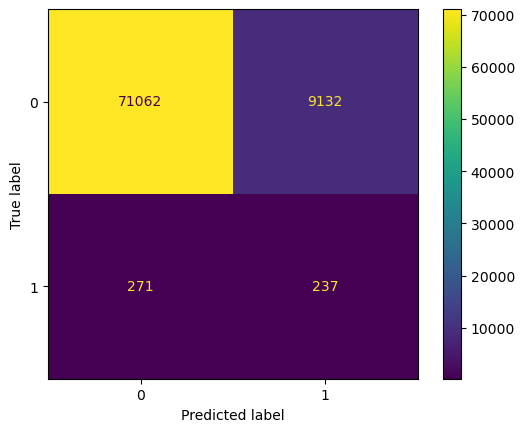

In [40]:
ConfusionMatrixDisplay.from_estimator(logr, X_test_tf, y_test);

#### Best recall score so far at 0.467.

In [41]:
recall_score(y_test, logr.predict(X_test_tf) )

0.46653543307086615

In [42]:
precision_score(y_test, logr.predict(X_test_tf) )

0.025296189561319245

#### But poor F1 score

In [43]:
f1_score(y_test, logr.predict(X_test_tf) )

0.04799028044952921

In [44]:
logr_tf_df = pd.DataFrame(logr.predict_proba(X_test_tf), columns = ['above_5th_percentile', 'below_5th_percentile'] )
logr_tf_df

,above_5th_percentile,below_5th_percentile
0,0.803087,0.196913
1,0.996976,0.003024
2,0.995501,0.004499
3,0.992293,0.007707
4,0.960467,0.039533
...,...,...
80697,0.991814,0.008186
80698,0.661423,0.338577
80699,0.927385,0.072615
80700,0.971455,0.028545


In [45]:
tf_logr_feature_names = pd.DataFrame(tf.get_feature_names_out(), columns = ['features'] )
tf_logr_feature_names

,features
0,00
1,000
2,001
3,007
4,00a
...,...
66845,１階のスペースを使ってくださいとフレキシブルでした
66846,２日間だけでしたが
66847,２０分歩けば大きなスーパーがあります
66848,５分


##### Strange words showing up - some foreign languages, etc.

In [46]:
tf_logr_word_probs = tf_logr_feature_names.join(logr_tf_df)
tf_logr_word_probs.sort_values('below_5th_percentile', ascending = False).head(20)

,features,above_5th_percentile,below_5th_percentile
50068,toffee,0.000003,0.999997
30033,looks,0.000045,0.999955
22625,gratuitous,0.000184,0.999816
6286,befürchten,0.000271,0.999729
64923,신석하고,0.000352,0.999648
45788,smoky,0.000477,0.999523
45774,smithsonians,0.000585,0.999415
48162,supernal,0.000594,0.999406
37468,pie,0.000677,0.999323
60520,感谢kelly和jack提供他们的整套公寓,0.000821,0.999179


In [47]:
tf_logr_word_probs.sort_values('above_5th_percentile', ascending = False).head(20)

,features,above_5th_percentile,below_5th_percentile
26404,interesse,1.000000,2.303060e-07
25060,hübsche,1.000000,4.410628e-07
11436,confortamble,1.000000,4.665855e-07
50997,tryna,0.999999,5.151329e-07
28127,knick,0.999999,5.918757e-07
56915,моя,0.999999,7.356169e-07
8700,caos,0.999999,8.669834e-07
49005,taverns,0.999999,8.899133e-07
37128,permitían,0.999999,1.063847e-06
21137,fué,0.999999,1.126599e-06


In [48]:
pd.set_option('display.max_colwidth', 400)
df[['avg_rating', 'avg_score_below_5th_percentile', 'comments_clean']] [df['comments_clean'].str.contains('toffee')].sort_values('avg_rating')

,avg_rating,avg_score_below_5th_percentile,comments_clean
216616,4.901429,0,we enjoyed our visit to dc and our stat at teri and eddie s place it was exactly how it s pictured in the listing perfect landing spot after exploring the city it had everything we needed it was close to public transit so we never missed having a car solid state books was a great bookstore right down the street and the fancy radish was a delicious dinner spot get the rutabaga fondue and sticky...


In [49]:
df[['avg_rating', 'avg_score_below_5th_percentile', 'comments_clean']] [df['comments_clean'].str.contains('gratuitous')].sort_values('avg_rating')

,avg_rating,avg_score_below_5th_percentile,comments_clean
316883,3.591429,1,we have been using airbnb for years and have had wonderful experiences all around the world this rental is by far the worst experience we have ever had with a house the house was dirty beds were not made there was trash in bathrooms and in the kitchen there were wet towels on the floors in all the restrooms we were very disappointed that we were never able to get in contact with the owner to g...
278414,4.837143,0,the brownstone is beautiful very well thought out and gives a very homely vibe the back patio is a nestled escape to unwind being a smart home is an added bonus and location is extremely convenient to reach anywhere in the city br codie is a gratuitous and communicative host who will make sure you have a wonderful time and want for nothing


In [50]:
df[['avg_rating', 'avg_score_below_5th_percentile', 'comments_clean']] [df['comments_clean'].str.contains('smoky')].sort_values('avg_rating')

,avg_rating,avg_score_below_5th_percentile,comments_clean
78664,4.751429,0,karl s place has potential but it was the little things that made me cancel and leave there was still a smoky unpleasant smell as you enter the tv remote was broken and did not work easily there is no thermostat in the apartment so a guest cannot easily adjust the temperature i knew the bathroom would be small from the reviews but the only mirror was above the toilet which made the little sink...
317161,4.892857,0,had a lovely stay here while in town for a conference easy checkin clean space and quick communication br like a few others i also noticed the smoky smell and i did not use the fireplace at all it came back each day it was warm enough that opening the windows to air things out for a little while did the trick
244181,4.925714,0,the place is as clean and bright as the photos i appreciate the space the full sized fridge toaster and microwave my first time using an induction top it does get a little smoky depending on what is being cooked so keeping the door open to avoid a fire department visit would be my suggestion the only window is in the bedroom br finally being in the basement we realize anne and sid have a very ...
205425,4.962857,0,what a beautiful hidden gem super clean comfortable and accommodating what a beautiful space in a quiet neighborhood great snacks and beverages options star has truly made a wonderful spot to stay even though it s 420 friendly the space isn t smoky at all i do not smoke just my boyfriend who stayed as well so even if you don t partake this is a wonderful place to stay


#### Lots of the words that show up as being strong predictors don't show up frequently in the corpus. So will run a GridSearch with min_df to try to improve this

In [51]:
pipe = Pipeline([
    ('tf', TfidfVectorizer() ),
    ('logr', LogisticRegression(class_weight = 'balanced') )
])

In [52]:
pipe_params = {
    'tf__stop_words' : ['english'],
    'tf__max_features' : [5_000, 10_000, 30_000],
    'tf__min_df' : [10, 25, 50, 100],  # Increase the minimum on the DF since I'm oversampling the minority class
    'tf__ngram_range': [ (1,1), (1,2), (1,3) ]
}

In [53]:
gs = GridSearchCV(pipe, pipe_params, n_jobs = -1, verbose = 10)

In [54]:
gs.fit(X_train_over['comments_clean'], y_train_over)

Fitting 5 folds for each of 36 candidates, totalling 180 fits


C:\Users\david\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


GridSearchCV(estimator=Pipeline(steps=[('tf', TfidfVectorizer()),
                                       ('logr',
                                        LogisticRegression(class_weight='balanced'))]),
             n_jobs=-1,
             param_grid={'tf__max_features': [5000, 10000, 30000],
                         'tf__min_df': [10, 25, 50, 100],
                         'tf__ngram_range': [(1, 1), (1, 2), (1, 3)],
                         'tf__stop_words': ['english']},
             verbose=10)

#### Best Params: 30k Max Features, Min DF 100, ngram_range: 1,2

In [55]:
gs.best_params_

{'tf__max_features': 30000,
 'tf__min_df': 10,
 'tf__ngram_range': (1, 2),
 'tf__stop_words': 'english'}

#### Best Score: 0.9695174162440768

In [56]:
gs.best_score_

0.9695485909053122

In [57]:
X_test

,comments_clean
26972,hands down one of the best experiences this place is just as good as you see in the pictures if not better our host was very friendly and full of great information that allowed us to navigate and explore the neighborhood 10 10 would deff recommend
58773,linden was very welcoming and ensured my stay was smooth and easy i really appreciated all thought that was put into my stay
135419,this place is amazing i would definitely recommend it john was really helpful in helping me get from dca to his place providing clear and thourough instructions when i got there i was struck by how nice the neighborhood was it was close to everything in the heart of georgetown shops restaurants etc nice area to walk and jog and get dinner the bed was soft as a cloud and the television was hd a...
203585,staying here was great very accommodating and i stayed for 5 months br kelvin and nakita are great host honestly the best br the location is great if you want to be near everything in the dc area the highway interstate is less than 5 mins away br we enjoyed being close to the suite way the nationals baseball park and more br you won t regret staying here if you need a something accommodating t...
55662,we greatly enjoyed our stay at home sweet city s place there was plenty of room the place was very clean and communication was great
...,...
124680,beautiful place to stay in dupont circle area very close to the metro station super cozy place comfy and simply awesome thank you for everything
276778,beautiful home with all the necessary amenities in a great location we didn t want to leave
270842,wonderful place to stay in dc especially for a family vacation very comfortable space for six people privacy for everyone with four bedrooms and four bathrooms outside deck is a nice place to unwind after long day at museums and monuments great food across the street and other places within walking distance large safeway grocery store is only a two block walk away however the highlight is defi...
11349,i enjoyed my stay at tommy s


In [58]:
gs.score(X_train_over['comments_clean'], y_train_over), gs.score(X_test['comments_clean'], y_test)

(0.9730193698561809, 0.941835394414017)

In [59]:
X_test.shape, y_test.shape

((80702, 1), (80702,))

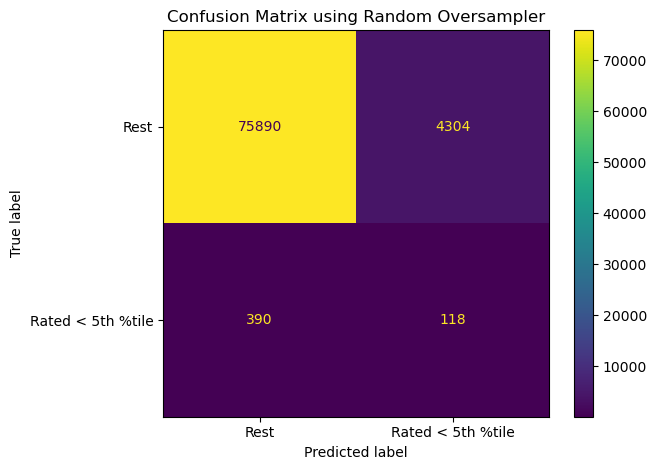

In [62]:
ConfusionMatrixDisplay.from_estimator(gs, X_test['comments_clean'], y_test,
                                     display_labels = ['Rest', 'Rated < 5th %tile'])

plt.title('Confusion Matrix using Random Oversampler')

plt.tight_layout()

plt.savefig('../images/07_oversample_confusion_matrix.png', dpi = 192);

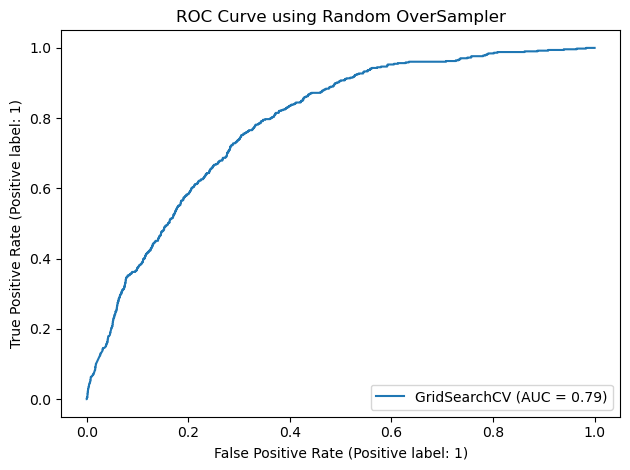

In [64]:
RocCurveDisplay.from_estimator(gs, X_test['comments_clean'], y_test)

plt.title('ROC Curve using Random OverSampler')

plt.tight_layout()

plt.savefig('../images/07_oversample_ROC_curve.png', dpi = 192);

##### Recall score of 0.23 - still lots of false positives

In [65]:
recall_score(y_test, gs.predict(X_test['comments_clean']) )

0.23228346456692914

In [66]:
f1_score(y_test, gs.predict(X_test['comments_clean']) )

0.04787018255578093

In [67]:
prob_df = pd.DataFrame(gs.predict_proba(gs.best_estimator_.named_steps.tf.get_feature_names_out() ), columns = ['above_5th_percentile', 'below_5th_percentile'])
prob_df

,above_5th_percentile,below_5th_percentile
0,0.724574,0.275426
1,0.396885,0.603115
2,0.257439,0.742561
3,0.306532,0.693468
4,0.193450,0.806550
...,...,...
29995,0.221421,0.778579
29996,0.547033,0.452967
29997,0.319444,0.680556
29998,0.171513,0.828487


In [68]:
feature_words = pd.DataFrame( gs.best_estimator_.named_steps.tf.get_feature_names_out(), columns = ['features'])
feature_words

,features
0,00
1,00 pm
2,000
3,000 br
4,02h
...,...
29995,호스트는 친절하였다
29996,화장실
29997,화장실 욕실이
29998,환불


In [71]:
word_probs = feature_words.join(prob_df)
word_probs.sort_values('above_5th_percentile', ascending = False).head(20)

,features,above_5th_percentile,below_5th_percentile
16114,loved stay,0.998808,0.001192
5665,comfortable,0.998525,0.001475
25274,stay perfect,0.997510,0.002490
15691,location perfect,0.997076,0.002924
19991,place convenient,0.996983,0.003017
1430,apartment comfortable,0.996783,0.003217
25956,super clean,0.996503,0.003497
15604,location clean,0.996429,0.003571
16141,lovely place,0.996387,0.003613
29331,wonderful location,0.996349,0.003651


In [77]:
top_20_neg_predictors = word_probs.sort_values('below_5th_percentile', ascending = False).head(20)
top_20_neg_predictors = top_20_neg_predictors.sort_values('below_5th_percentile', ascending = True)
top_20_neg_predictors

,features,above_5th_percentile,below_5th_percentile
26715,time jasmine,6.325154e-05,0.999937
13959,jasmine wasn,6.186844e-05,0.999938
26837,todd,5.981747e-05,0.999940
6214,conocer jasmine,5.223442e-05,0.999948
12810,host jasmine,4.919562e-05,0.999951
13946,jasmine house,4.770017e-05,0.999952
29667,yousong sharon,4.470180e-05,0.999955
13955,jasmine safety,4.066437e-05,0.999959
17302,ms jasmine,3.755226e-05,0.999962
7318,dee place,3.425993e-05,0.999966


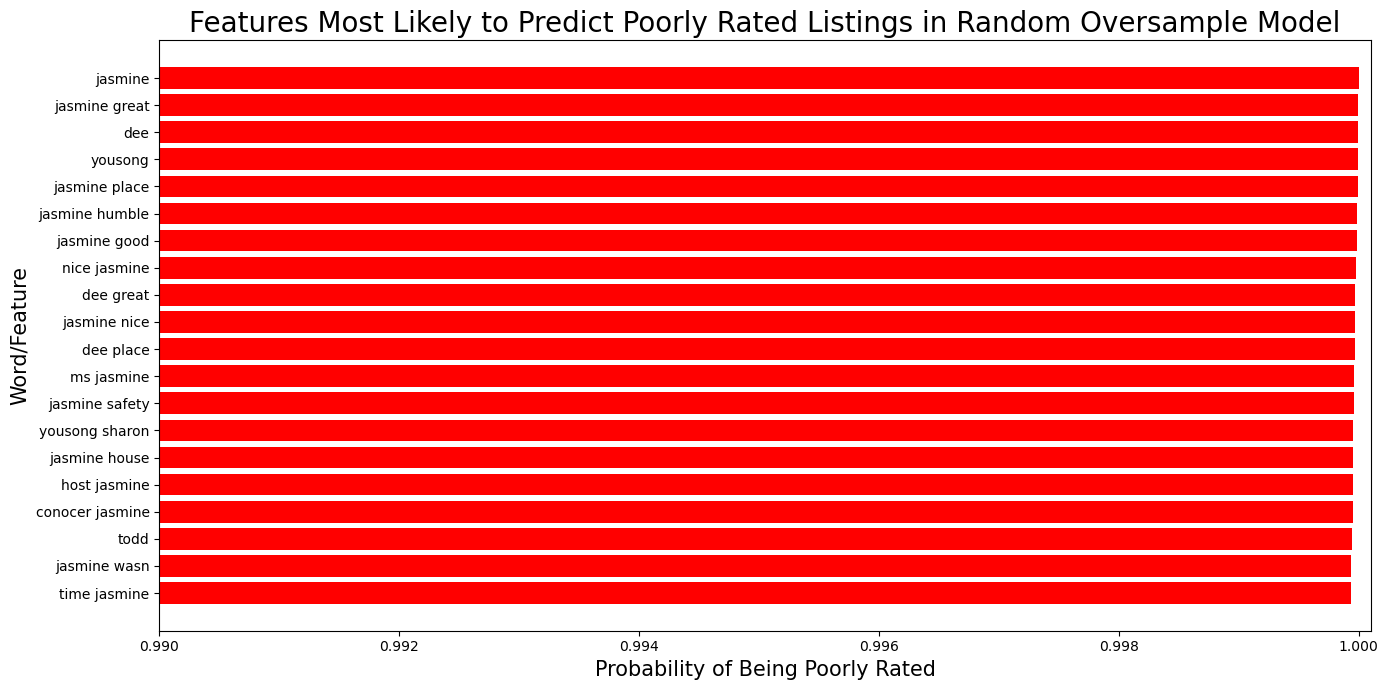

In [82]:
plt.figure(figsize = (14,7))

plt.barh(top_20_neg_predictors['features'],
        top_20_neg_predictors['below_5th_percentile'], color = 'red')

plt.xlim(0.99, 1.0001)
plt.xlabel('Probability of Being Poorly Rated', fontsize = 15)
plt.ylabel('Word/Feature', fontsize = 15)

plt.title('Features Most Likely to Predict Poorly Rated Listings in Random Oversample Model', fontsize = 20)

plt.tight_layout()

plt.savefig('../images/07_random_oversample_predicted_features.png', dpi = 192);

In [57]:
df.head()

,listing_id,id,date,reviewer_id,reviewer_name,comments,avg_rating,avg_score_below_4,avg_score_below_5th_percentile,comments_clean
0,3686,131293,2010-11-01,257234,Callie,"Staying with Levita and her wonderful family was an amazing experience. They were so welcoming to me and her home was great. I cannot express enough how nice my experience was. Not only is Levita's home very close to the metro, extremely comfortable, but her vegan cooking was incredible as well. Anyone would be lucky to stay with such a friendly, welcoming family.",4.588571,0,0,staying with levita and her wonderful family was an amazing experience they were so welcoming to me and her home was great i cannot express enough how nice my experience was not only is levita s home very close to the metro extremely comfortable but her vegan cooking was incredible as well anyone would be lucky to stay with such a friendly welcoming family
1,3686,150766,2010-12-08,255888,Patrick,"Vita is a very welcoming, helpful and friendly host and a great cook. Her house is located in an interesting, not to say fascinating, area of Washington DC. Transport connections are close by and very frequent, the house (and the room where I stayed) are furnished in a very elegant style and I was always happy to come home in the evening to the friendly atmosphere of the household of Vita and ...",4.588571,0,0,vita is a very welcoming helpful and friendly host and a great cook her house is located in an interesting not to say fascinating area of washington dc transport connections are close by and very frequent the house and the room where i stayed are furnished in a very elegant style and i was always happy to come home in the evening to the friendly atmosphere of the household of vita and her two ...
2,3686,177749,2011-02-02,366688,Benjamin,"This was my first time using ""airbnb"" and it made me wonder why I ever stayed in hotels in the past!! Vita was the most incredible host. Her home was warm and inviting, full of beautiful artwork and artistic people. The bedroom was immaculately clean and comfortable. It felt like a vacation...I even started my morning with a hot, leisurely bath! Vita is a wonderful chef, and runs an awesome f...",4.588571,0,0,this was my first time using airbnb and it made me wonder why i ever stayed in hotels in the past vita was the most incredible host her home was warm and inviting full of beautiful artwork and artistic people the bedroom was immaculately clean and comfortable it felt like a vacation i even started my morning with a hot leisurely bath vita is a wonderful chef and runs an awesome food blog where...
3,3686,197451,2011-03-12,213492,T.J.,"First, Vita saved my work week by providing me with very very very last minute acomodations. Vita's home was an absolute urban oasis! I was absolutely comfortable with the private accomodations. I regret not being able to spend more time with Vita and her family. I had a wonderful stay and look forward to being a guest in the future.",4.588571,0,0,first vita saved my work week by providing me with very very very last minute acomodations vita s home was an absolute urban oasis i was absolutely comfortable with the private accomodations i regret not being able to spend more time with vita and her family i had a wonderful stay and look forward to being a guest in the future
4,3686,213212,2011-03-30,428455,Pete,"Great host! Very welcoming and organised. I stayed for three nights while sightseeing in D.C. - the location is very convenient and Vita provided maps and guides. The room is lovely, the shower is hot and Vita shared her tasty vegan cooking! Would happily stay again.",4.588571,0,0,great host very welcoming and organised i stayed for three nights while sightseeing in d c the location is very convenient and vita provided maps and guides the room is lovely the shower is hot and vita shared her tasty vegan cooking would happily stay again


In [58]:
pd.set_option('display.max_colwidth', 400)
df[['avg_rating', 'listing_id', 'avg_score_below_5th_percentile', 'comments_clean']] [df['comments_clean'].str.contains('jasmine')].sort_values('avg_rating').head(50)

,avg_rating,listing_id,avg_score_below_5th_percentile,comments_clean
302045,4.352857,702842898980509221,1,initially at booking jasmine wasn t responsive to questions however as the date approached and came she was very responsive had all the items to help our holiday away from home feel homey enjoyed our stay
302043,4.352857,702842898980509221,1,jasmine was very nice she was very responsive and made excellent recommendations public transit was very close by so even though there wasn t much to do in the area we were able to get where we needed with ease would stay again
302040,4.352857,702842898980509221,1,a great place and responsive host the place was very nice and the instructions were clear mattresses were very comfortable the kitchen was very nice and clean and the living room was very nice jasmine was great at checking in and responding to a couple questions we had would definitely stay here again
302038,4.352857,702842898980509221,1,jasmine house was very clean and nice and she got lots of kitchen equipment for people who like to cook we will be here again for sure
302037,4.352857,702842898980509221,1,very cozy house and communication with jasmine was always very fluid everything was great
302032,4.352857,702842898980509221,1,do not stay here especially if you have a family unless you enjoy walking outside and getting a contact high from people smoking pot i totally understand that pot is legal in dc but instead of saying it s a quiet place it should have been described as partying neighbors we went outside to move our truck to the back of the house and all we could smell was pot when i messaged jasmine about the s...
302029,4.352857,702842898980509221,1,great layout comfortable rooms great well stocked kitchen and two free parking options jasmine s home was very comfortable convenient and cute
302026,4.352857,702842898980509221,1,jasmine was wonderful to work with her place is well maintained and had all we needed for our family
302025,4.352857,702842898980509221,1,not our first time staying in jasmine s place and won t be the last br we absolutely loved it there br the apartment was super peaceful and in a great neighborhood br and jasmine always took care of us no matter what we needed
302018,4.352857,702842898980509221,1,jasmine s place was perfect for our family outing it was clean well maintained and had everything you needed it was also very close to the capitol


In [137]:
pd.set_option('display.max_colwidth', 50)
listings = pd.read_csv('../data/listings.csv')
listings.head()

,id,listing_url,scrape_id,last_scraped,source,name,description,neighborhood_overview,picture_url,host_id,...,review_scores_communication,review_scores_location,review_scores_value,license,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
0,3686,https://www.airbnb.com/rooms/3686,20240323200252,2024-03-24,city scrape,Vita's Hideaway,IMPORTANT NOTES<br />* Carefully read and be s...,We love that our neighborhood is up and coming...,https://a0.muscache.com/pictures/61e02c7e-3d66...,4645,...,4.84,3.91,4.64,NaN,f,1,0,1,0,0.52
1,3943,https://www.airbnb.com/rooms/3943,20240323200252,2024-03-23,city scrape,Historic Rowhouse Near Monuments,You will be staying in high ceiling bedroom w...,This rowhouse is centrally located in the hear...,https://a0.muscache.com/pictures/airflow/Hosti...,5059,...,4.91,4.58,4.75,Hosted License: 5007242201001033,f,5,0,5,0,2.75
2,4197,https://www.airbnb.com/rooms/4197,20240323200252,2024-03-24,city scrape,Capitol Hill Bedroom walk to Metro,This is the middle bedroom upstairs in a resto...,"Our area, the Eastern Market neighborhood of C...",https://a0.muscache.com/pictures/miso/Hosting-...,5061,...,4.98,4.96,4.95,Hosted License: 5007242201000749,f,2,0,2,0,0.33
3,4529,https://www.airbnb.com/rooms/4529,20240323200252,2024-03-23,city scrape,Bertina's House Part One,This is large private bedroom with plenty of...,Very quiet neighborhood and it is easy accessi...,https://a0.muscache.com/pictures/86072003/6709...,5803,...,4.93,4.51,4.83,Exempt,f,2,0,2,0,0.57
4,5589,https://www.airbnb.com/rooms/5589,20240323200252,2024-03-24,city scrape,Cozy apt in Adams Morgan,This is a 1 br (bedroom + living room in Adams...,"Adams Morgan spills over with hipsters, salsa ...",https://a0.muscache.com/pictures/miso/Hosting-...,6527,...,4.82,4.91,4.44,NaN,f,1,1,0,0,0.54


In [139]:
pd.set_option('display.max_columns', 80)
listings[listings['id'] == 702842898980509221]

,id,listing_url,scrape_id,last_scraped,source,name,description,neighborhood_overview,picture_url,host_id,host_url,host_name,host_since,host_location,host_about,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_thumbnail_url,host_picture_url,host_neighbourhood,host_listings_count,host_total_listings_count,host_verifications,host_has_profile_pic,host_identity_verified,neighbourhood,neighbourhood_cleansed,neighbourhood_group_cleansed,latitude,longitude,property_type,room_type,accommodates,bathrooms,bathrooms_text,bedrooms,beds,amenities,price,minimum_nights,maximum_nights,minimum_minimum_nights,maximum_minimum_nights,minimum_maximum_nights,maximum_maximum_nights,minimum_nights_avg_ntm,maximum_nights_avg_ntm,calendar_updated,has_availability,availability_30,availability_60,availability_90,availability_365,calendar_last_scraped,number_of_reviews,number_of_reviews_ltm,number_of_reviews_l30d,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,license,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
2861,702842898980509221,https://www.airbnb.com/rooms/702842898980509221,20240323200252,2024-03-24,city scrape,Residential Neighborhood Suitable for Quiet Stays,"Set in the Northeast corner of DC, this home i...","One of the oldest neighborhoods in Washington,...",https://a0.muscache.com/pictures/miso/Hosting-...,6688891,https://www.airbnb.com/users/show/6688891,Jasmine,2013-06-01,"Washington, DC",I’m a DMV native. I travel often and rent my o...,within an hour,88%,90%,f,https://a0.muscache.com/im/pictures/user/12076...,https://a0.muscache.com/im/pictures/user/12076...,Deanwood,3,4,"['email', 'phone', 'work_email']",t,t,"Washington, District of Columbia, United States","Deanwood, Burrville, Grant Park, Lincoln Heigh...",NaN,38.90095,-76.92674,Entire home,Entire home/apt,6,2.0,2 baths,3.0,6.0,"[""Microwave"", ""Dining table"", ""Hair dryer"", ""B...",$145.00,3,60,3,3,1125,1125,3.0,1125.0,NaN,t,14,38,68,328,2024-03-24,30,16,0,2022-09-23,2024-01-05,4.3,4.43,4.37,4.6,4.37,4.1,4.3,Hosted License: 5007242201001640<br />Unhosted...,f,2,2,0,0,1.64
